# Projeto Final - IA006 Machine Learning



    Alunos: Fernanda Ferreira RA:163676

            Renan Brotto RA:137442
        
        
Professores: Levy Boccato e Romis Attux

Data: 01/07/2019

# Reconhecimento de Imagens Open Set com Redes Neurais Siamesas

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv1D
%matplotlib inline
import matplotlib.pyplot as plt

#num_classes = 3
epochs = 5


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

#def create_base_network(input_shape):
#    
#    Model=Sequential()
#    Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#    Model.add(MaxPooling2D(pool_size=(2, 2)))
#    Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
#    Model.add(MaxPooling2D(pool_size=(2, 2)))
#    Model.add(Flatten())
    #Model.add(Dense(100, activation='relu')) #200
    # Output Layer
    #Model.add(Dense(1, activation='softmax'))
    #Model.summary()
#    return Model

#def create_pairs(x, digit_indices, num_classes):
#    '''Positive and negative pair creation.
#    Alternates between positive and negative pairs.
#    '''
#    pairs = []
#    labels = []
#    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
#    for d in range(num_classes):
#        for i in range(n):
#            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
#            pairs += [[x[z1], x[z2]]]
#            inc = random.randrange(1, num_classes)
#            dn = (d + inc) % num_classes
#            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
#            pairs += [[x[z1], x[z2]]]
#            labels += [0, 1]
#    return np.array(pairs), np.array(labels)


def create_pairs(x, y, digit_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    y_pairs = []
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            y_pairs += [[y[z1], y[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            y_pairs += [[y[z1], y[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(y_pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

/home/fernanda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Dataset utilizado: Mnist

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print (input_shape)

(28, 28)


### Criação de pares para a entrada da rede

In [3]:
digit_indices = [np.where(y_train == i)[0] for i in range(6)]
tr_pairs, try_pairs, tr_y = create_pairs(x_train, y_train, digit_indices, 6)

In [4]:
digit_indices2 = [np.where(y_test == i)[0] for i in range(8)]
te_pairs, tey_pairs, te_y = create_pairs(x_test, y_test, digit_indices2, 8)


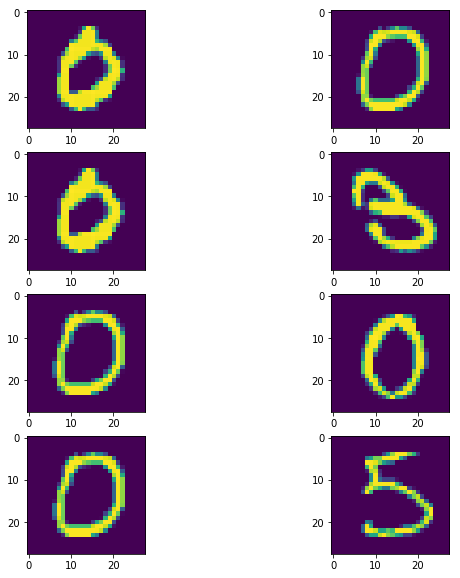

[0 0] [0 3] [0 0] [0 5]
[1 0 1 0]


In [5]:
fig, ax = plt.subplots(4, 2, figsize=(10,10))

ax[0][0].imshow(te_pairs[0][0])
ax[0][1].imshow(te_pairs[0][1])
ax[1][0].imshow(te_pairs[1][0])
ax[1][1].imshow(te_pairs[1][1])
ax[2][0].imshow(te_pairs[2][0])
ax[2][1].imshow(te_pairs[2][1])
ax[3][0].imshow(te_pairs[3][0])
ax[3][1].imshow(te_pairs[3][1])
plt.show()

print (tey_pairs[0], tey_pairs[1], tey_pairs[2], tey_pairs[3])
print (te_y[0:4])

Quando os pares são iguais, são rotulados como 1 e quando os pares são diferentes são rotulados como 0.

### Definição da arquitetura da rede

In [6]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           26176       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

### O modelo da rede foi obtido utilizando os dados de treinamento e validação para ajuste dos parâmetros da função custo.

In [8]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit([tr_pairs[0:50000, 0], tr_pairs[0:50000, 1]], tr_y[0:50000],
          batch_size=128,
          epochs=5,
          validation_data=([tr_pairs[50000:len(tr_pairs), 0], tr_pairs[50000:len(tr_pairs), 1]], tr_y[50000:len(tr_pairs)]))

#model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#          batch_size=128,
#          epochs=epochs,
#          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 50000 samples, validate on 15040 samples
Epoch 1/5
50000/50000 [==============================] - 4s 74us/step - loss: 0.1326 - accuracy: 0.8202 - val_loss: 0.3965 - val_accuracy: 0.6771
Epoch 2/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.0690 - accuracy: 0.9293 - val_loss: 0.6025 - val_accuracy: 0.6650
Epoch 3/5
50000/50000 [==============================] - 3s 54us/step - loss: 0.0530 - accuracy: 0.9497 - val_loss: 0.7769 - val_accuracy: 0.6581
Epoch 4/5
50000/50000 [==============================] - 3s 55us/step - loss: 0.0415 - accuracy: 0.9654 - val_loss: 0.9974 - val_accuracy: 0.6499
Epoch 5/5
50000/50000 [==============================] - 3s 54us/step - loss: 0.0358 - accuracy: 0.9709 - val_loss: 1.2773 - val_accuracy: 0.6483


In [9]:
# compute final accuracy on training and test sets
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)

y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('Acurácia para o conjunto de treinamento: %0.2f%%' % (100 * tr_acc))
print('Acurácia para o conjunto de teste: %0.2f%%' % (100 * te_acc))



Acurácia para o conjunto de treinamento: 90.59%
Acurácia para o conjunto de teste: 83.43%


### Matriz mostrando os pares, o rótulo e o valor da predição de acordo com a distância Euclidiana obtida no conjunto de teste.

In [10]:
#len(tey_pairs), len(y_pred_te), len(te_y)

matriz_results = np.zeros((len(te_y), 4))
for i in range(len(te_y)):
    matriz_results[i][0:2] = tey_pairs[i]
    matriz_results[i][2] = te_y[i]
    matriz_results[i][3] = y_pred_te[i]
    
#m_res = np.hstack((matriz_results, y_pred_te))

np.set_printoptions(precision=4, suppress=True)
print ((matriz_results))

[[0.     0.     1.     0.0499]
 [0.     3.     0.     0.7795]
 [0.     0.     1.     0.1038]
 ...
 [7.     6.     0.     0.7416]
 [7.     7.     1.     0.461 ]
 [7.     6.     0.     0.5859]]


### Matriz apenas com os pares que são diferentes

In [11]:
matriz_diff = []
for i in range(len(te_y)):
    if matriz_results[i][2] == 0:
        matriz_diff.append(matriz_results[i])
       # input()
#print (matriz_diff)
        
matriz_diff = np.array(matriz_diff)

#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=10) 
print (matriz_diff)
#print (min(matriz_diff[:, 3]))

[[0.     3.     0.     0.7795]
 [0.     5.     0.     1.1853]
 [0.     5.     0.     2.8035]
 ...
 [7.     5.     0.     0.648 ]
 [7.     6.     0.     0.7416]
 [7.     6.     0.     0.5859]]


In [12]:
n_pert = []
pert = []
for i in range(len(matriz_diff)):
    if 0.15 < matriz_diff[i][3] < 0.85:
        n_pert.append(matriz_diff[i][0:2])
    else:
        pert.append(matriz_diff[i][0:2])
        
#print (len(n_pert))
#print (len(pert))

Após algumas análises, podemos observar que as imagens que não pertencem ao conjunto (imagens que representam os números 6 e 7) resultaram em distâncias menores que 0,85 e maiores que 0,15 aproximadamente. Para o caso contrário, os pares que são diferentes, porém pertencem ao conjunto, resultaram em distâncias muito próximas de 1. Portanto, para identificar as imagens que não pertencem ao conjunto utilizamos um threshold de range 0,15 e 0,85.


In [13]:
y_true_diff = np.zeros((len(matriz_diff), 1))
y_pred_diff = np.zeros((len(matriz_diff), 1))

for i in range(len(matriz_diff)):
    if matriz_diff[i][0] == 6 or matriz_diff[i][0]==7 or matriz_diff[i][1] == 6 or matriz_diff[i][1]==7:
        y_true_diff[i] = 1
    else:
        y_true_diff[i] = 0
    
    if 0.15 < matriz_diff[i][3] < 0.85: 
        y_pred_diff[i] = 1
    else:
        y_pred_diff[i] = 0
        
#np.set_printoptions(threshold=np.inf)       
#print (y_true_diff)
#print (y_pred_diff)

In [14]:
a = e = 0
for i in range(len(y_true_diff)):
    if y_true_diff[i] == y_pred_diff[i]:
        a += 1
    else:
        e += 1
        
ACC = a/len(y_true_diff)
print ('Quantidade de acertos', a)
print ('Quantidade de erros:', e)
print ('Acurácia para identificar as imagens que não pertencem ao conjunto: ', ACC)

Quantidade de acertos 5073
Quantidade de erros: 2055
Acurácia para identificar as imagens que não pertencem ao conjunto:  0.7117003367003367


## Identificação das imagens que não pertencem ao conjunto de dados

Sabemos que as imagens que não pertencem ao conjunto representam os números 6 e 7. Entretanto, se não soubéssemos quais seriam as imagens, poderíamos verificar qual a quantidade de ocorrências que as imagem aparecem de acordo com o threshold escolhido. 

Dessa maneira, podemos verificar que as ocorrências das imagens 6 e 7, as quais representam os números 6 e 7, que foram classificadas como "pertencem ao conjunto" apresentam menores ocorrências quando comparado com as outras imagens. Logo, para as imagens classificadas como "não pertencem ao conjunto" apresentam maiores ocorrências para as imagens 6 e 7. Assim, podemos concluir que as imagens que representam os números 6 e 7 não pertencem ao conjunto de dados.

In [15]:
def count_datas(n):
    n = np.array(n)
    n_data = n.ravel()

    for i in range(8):
        n_count = (list(n_data)).count(i)
        print (i, ":", "{0:.2f}".format(((n_count/len(n))*100)), "%")

print ('Porcentagem de imagens que mais ocorreram que PERTENCEM ao conjunto de dados')
print (count_datas(pert))
print ('Porcentagem de imagens que mais ocorreram que NÃO PERTENCEM ao conjunto de dados')
print (count_datas(n_pert))

Porcentagem de imagens que mais ocorreram que PERTENCEM ao conjunto de dados
0 : 24.20 %
1 : 32.33 %
2 : 22.42 %
3 : 28.48 %
4 : 25.48 %
5 : 35.52 %
6 : 16.88 %
7 : 14.70 %
None
Porcentagem de imagens que mais ocorreram que NÃO PERTENCEM ao conjunto de dados
0 : 26.24 %
1 : 9.05 %
2 : 33.01 %
3 : 18.26 %
4 : 24.25 %
5 : 5.62 %
6 : 40.06 %
7 : 43.52 %
None


## Conclusão

A rede siamesa atingiu uma acurácia de 0,68. Um dos problemas para esse valor seria as imagens escolhidas para compor o conjunto de treino e teste. Por exemplo: algumas imagens de 1 e 7 ; 0 e 6 são muito similares, o que poderia prejudicar o resultado de classificação dos dados. Ou seja, as distâncias euclidianas apresentam valores diferentes do rotulado.

## Referências

- https://github.com/keras-team/keras
- https://www.kaggle.com/arpandhatt/siamese-neural-networks
- https://www.kaggle.com/kmader/image-similarity-with-siamese-networks
- https://software.intel.com/en-us/articles/keras-implementation-of-siamese-like-networks